In [2]:
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = '/kaggle/input/russian-legal-text-parallel-corpus/legal_text_corpus.csv'

In [4]:
df = pd.read_csv(data_path)

In [5]:
df.dropna(inplace=True)

In [6]:
df['Длина_текста'] = df['Текст'].apply(len)

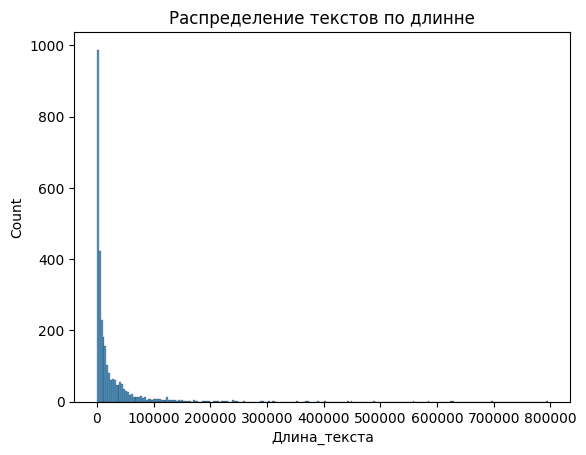

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.title('Распределение текстов по длинне')
sns.histplot(x='Длина_текста', data=df)
plt.show()

In [9]:
small_len = df[df['Длина_текста'] <= 5000]
df = small_len

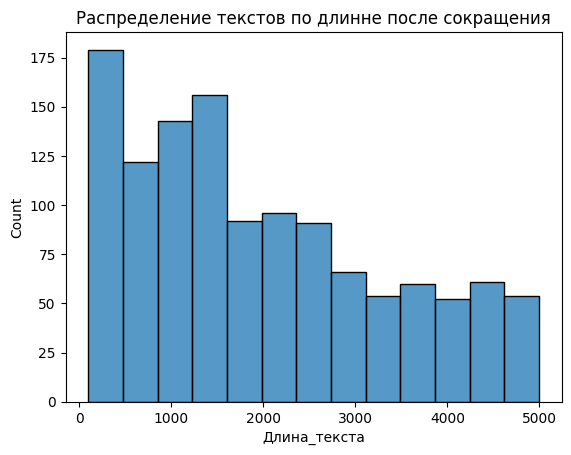

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.title('Распределение текстов по длинне после сокращения')
sns.histplot(x='Длина_текста', data=df)
plt.show()

In [11]:
import re

def remove_urls(text):
    # Регулярное выражение для нахождения URL
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('', text).strip()

# Пример использования
text_with_url = "https://example.com и http://test.org"
clean_text = remove_urls(text_with_url)
print(clean_text)  

и


In [12]:
df["Текст"] = df["Текст"].apply(remove_urls)

In [13]:
import pandas as pd
from tqdm import tqdm
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM

# Проверяем доступность GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Используется устройство: {device}")

# Загружаем модель для перевода
model_name = "Helsinki-NLP/opus-mt-ru-en"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
translator = pipeline("translation", model=model, tokenizer=tokenizer, device=0 if device == "cuda" else -1)

def split_text(text, max_chunk_size=500):
    """Разбивает текст на части по предложениям или по max_chunk_size символов"""
    sentences = text.split('. ')
    chunks = []
    current_chunk = ""
    
    for sentence in sentences:
        if len(current_chunk) + len(sentence) < max_chunk_size:
            current_chunk += sentence + '. '
        else:
            if current_chunk:
                chunks.append(current_chunk)
            current_chunk = sentence + '. '
    
    if current_chunk:
        chunks.append(current_chunk)
    

    if not chunks or any(len(chunk) > max_chunk_size * 1.5 for chunk in chunks):
        chunks = [text[i:i+max_chunk_size] for i in range(0, len(text), max_chunk_size)]
    
    return chunks

def translate_long_text(text, max_length=512):
    if pd.isna(text) or not text.strip():
        return None
    
    try:
        if len(text) <= max_length:
            return translator(text, max_length=max_length)[0]['translation_text']
        
        chunks = split_text(text)
        translated_chunks = []
        
        for chunk in chunks:
            if not chunk.strip():
                continue
            translated = translator(chunk, max_length=max_length)[0]['translation_text']
            translated_chunks.append(translated)
        
        return " ".join(translated_chunks)
    
    except Exception as e:
        print(f"Ошибка перевода: '{text[:50]}...' - {str(e)}")
        return None

def translate_dataframe_column(df, column_name='Текст', batch_size=8):
    tqdm.pandas(desc="Перевод текста")
    
    df['Текст_перевод'] = df[column_name].progress_apply(translate_long_text)
    
    return df

if __name__ == "__main__":
    
    translated_df = translate_dataframe_column(df[['Текст', 'Комментарий РГ']])
    
    print("\nРезультаты перевода:")
    print(translated_df)
    
    # Проверяем длину переведенных текстов
    if 'Текст_перевод' in translated_df:
        translated_df['Длина_оригинала'] = translated_df['Текст'].str.len()
        translated_df['Длина_перевода'] = translated_df['Текст_перевод'].str.len()
        print("\nСтатистика по длине текстов:")
        print(translated_df[['Длина_оригинала', 'Длина_перевода']])

Используется устройство: cuda


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

Device set to use cuda:0
Перевод текста: 100%|██████████| 1226/1226 [1:23:43<00:00,  4.10s/it]


Результаты перевода:
                                                  Текст  \
0     1. Внести в Указ временно исполняющего обязанн...   
7     1. Уволить с военной службы студентов, призван...   
8     Правительство Российской Федерации постановляе...   
11    Принят Государственной Думой 27 октября 2022 г...   
12    Принят Государственной Думой 27 октября 2022 г...   
...                                                 ...   
2937  Принят Государственной Думой 26 июня 2009 года...   
2939  Принят Государственной Думой 17 июля 2009 года...   
2940  Зарегистрирован в Минюсте РФ 23 июля 2009 г.  ...   
2950  Зарегистрирован в Минюсте РФ 14 августа 2009 г...   
2954  Зарегистрирован в Минюсте РФ 6 августа 2009 г....   

                                         Комментарий РГ  \
0     Врио главы ДНР Денис Пушилин подписал указ об ...   
7     Указ об увольнении с военной службы студентов ...   
8     Кабмин установил размер пособия по безработице...   
11    Федеральный закон "О мобили

In [21]:
!pip install nltk pandas textaugment

In [23]:
df

,Название документа,Ссылка,Текст,Комментарий РГ,Дата,Длина_текста
0,Указ временно исполняющего обязанности главы Д...,https://rg.ru/documents/2022/11/28/dnr-ukaz37-...,1. Внести в Указ временно исполняющего обязанн...,Врио главы ДНР Денис Пушилин подписал указ об ...,2022-11-28,856
7,Указ временно исполняющего обязанности главы Д...,https://rg.ru/documents/2022/11/18/dnr-ukaz30-...,"1. Уволить с военной службы студентов, призван...",Указ об увольнении с военной службы студентов ...,2022-11-18,473
8,Постановление Правительства Российской Федерац...,https://rg.ru/documents/2022/11/17/document-po...,Правительство Российской Федерации постановляе...,Кабмин установил размер пособия по безработице...,2022-11-17,982
11,Федеральный закон от 4 ноября 2022 г. N 421-ФЗ...,https://rg.ru/documents/2022/11/08/fz421.html,Принят Государственной Думой 27 октября 2022 г...,"Федеральный закон ""О мобилизационной подготовк...",2022-11-08,1787
12,Федеральный закон от 4 ноября 2022 г. N 433-ФЗ...,https://rg.ru/documents/2022/11/08/fz433.html,Принят Государственной Думой 27 октября 2022 г...,Государственные охотничьи инспекторы получили ...,2022-11-08,2890
...,...,...,...,...,...,...
2937,"Изменения в статье 21 ФЗ ""О ветеранах"" — Росси...",https://rg.ru/2009/07/21/veteran-dok.html,Принят Государственной Думой 26 июня 2009 года...,"Сегодня ""Российская газета"" публикует поправки...",2009-07-21,2029
2939,Федеральный закон N 216-ФЗ о внесении изменени...,https://rg.ru/2009/07/31/zakon-dok.html,Принят Государственной Думой 17 июля 2009 года...,"Изменения к статье 178 Уголовного кодекса, кот...",2009-07-31,3386
2940,Приказ Минпромторга об утверждении Перечня льг...,https://rg.ru/2009/08/04/avto-lgotn-dok.html,Зарегистрирован в Минюсте РФ 23 июля 2009 г. ...,"Сегодня ""Российская газета"" публикует приказ м...",2009-08-20,1102
2950,Нормы радиационной безопасности (НРБ-99/2009) ...,https://rg.ru/2009/09/11/nrb-dok.html,Зарегистрирован в Минюсте РФ 14 августа 2009 г...,В России введены новые нормы радиационной безо...,2009-09-11,1702


In [2]:
from datasets import Dataset

In [16]:
# Преобразуем в Dataset
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.2)

save_path = "./my_processed_datase"
dataset.save_to_disk(save_path)

Saving the dataset (0/1 shards):   0%|          | 0/980 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/246 [00:00<?, ? examples/s]

In [3]:
import os
from datasets import Dataset

dataset = load_from_disk("/kaggle/working/my_processed_datase")

desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop')
save_path = os.path.join(desktop_path, 'my_processed_dataset')

# Сохраняем датасет
dataset.save_to_disk(save_path)

NameError: name 'df' is not defined

In [7]:
import os
from datasets import load_from_disk

# Проверьте содержимое рабочей директории
print(os.listdir("/kaggle/working/"))

# Если папка существует, попробуйте загрузить
if "my_processed_datase" in os.listdir("/kaggle/working/"):
    try:
        dataset = load_from_disk("/kaggle/working/my_processed_datase")
        print("Датасет успешно загружен!")
        print(dataset)
    except Exception as e:
        print(f"Ошибка загрузки: {e}")
else:
    print("Папка с датасетом не найдена.")

['results', '.virtual_documents', 'my_processed_datase']
Датасет успешно загружен!
DatasetDict({
    train: Dataset({
        features: ['Название документа', 'Ссылка', 'Текст', 'Комментарий РГ', 'Дата', 'Длина_текста', '__index_level_0__'],
        num_rows: 980
    })
    test: Dataset({
        features: ['Название документа', 'Ссылка', 'Текст', 'Комментарий РГ', 'Дата', 'Длина_текста', '__index_level_0__'],
        num_rows: 246
    })
})


In [7]:
df['Текст'][0]

'1. Внести в Указ временно исполняющего обязанности Главы Донецкой Народной Республики от 18 ноября 2022 г. № 30 изменение, изложив пункт 1 в следующей редакции:  "1. Уволить с военной службы граждан, призванных на военную службу по мобилизации, получавших на момент их призыва образование соответствующего уровня впервые, обучавшихся по очной и очно-заочной формам обучения:  1.1. В образовательных и научных организациях по имеющим государственную аккредитацию образовательным программам среднего профессионального и высшего образования (в том числе программам ординатуры и программам ассистентуры-стажировки).  1.2. В образовательных и научных организациях по программам подготовки научных и научно-педагогических кадров в аспирантуре.".  2. Настоящий Указ вступает в силу со дня его подписания.  Врио Главы Донецкой Народной Республики Д.В.Пушилин      '

In [8]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

def preprocess_function(examples):
    inputs = ["simplify: " + text for text in examples["Текст"]]
    targets = examples["Комментарий РГ"]
    
    # Токенизация входов и выходов
    model_inputs = tokenizer(
        inputs, 
        max_length=256, 
        truncation=True, 
        padding="max_length"
    )
    
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets, 
            max_length=256, 
            truncation=True, 
            padding="max_length"
        )
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Применяем токенизацию ко всему датасету
tokenized_datasets = dataset.map(preprocess_function, batched=True)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/980 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3953: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/246 [00:00<?, ? examples/s]

In [9]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer


training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    num_train_epochs=3,
    save_total_limit=2,
    logging_dir="./local_logs",  # Локальное логирование
    report_to="none",           # Никаких внешних сервисов
    fp16=False,                # Отключаем FP16, так как он требует GPU
    gradient_checkpointing=True,
    no_cuda=True               # Явно указываем использование CPU
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)

trainer.train()

<ipython-input-9-34ead95441d9>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss
1,No log,2.412088
2,No log,2.371521
3,2.632300,2.356065


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


TrainOutput(global_step=735, training_loss=2.5914528360172193, metrics={'train_runtime': 3402.3358, 'train_samples_per_second': 0.864, 'train_steps_per_second': 0.216, 'total_flos': 198952448163840.0, 'train_loss': 2.5914528360172193, 'epoch': 3.0})

In [36]:
model = trainer.model

text = "In case of changes, B record an act of civil status based on a medical opinion of the medical commission of a medical organization subordinate to the federal executive authority responsible for the development and implementation of state policy and regulatory regulation in the field of healthcare, on the conformity of sexual characteristics with those of a certain sex, issued in accordance with part 2 of Article 45.1 of the Federal Law  On the Fundamentals of Health Protection of Citizens of the Russian Federation Of the Russian Federation, - a copy of the conclusion of the body responsible for the state registration of acts of civil status on the territory of the Russian Federation, on making corrections or amendments to the record of the act of civil status."

# Токенизация и суммаризация
inputs = tokenizer("summarize and simplify and paraphrase:" + text, return_tensors="pt", max_length=512, truncation=True)


summary_ids = model.generate(inputs["input_ids"], max_length=150, min_length=30, length_penalty=2.0, num_beams=15, early_stopping=True)
# Декодирование и вывод результата
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(summary)

print('------------------------')

print('In case of changes, B record an act of civil status based on a medical opinion of the medical commission of a medical organization subordinate to the federal executive authority responsible for the development and implementation of state policy and regulatory regulation in the field of healthcare, on the conformity of sexual characteristics with those of a certain sex, issued in accordance with part 2 of Article 45.1 of the Federal Law "On the Fundamentals of Health Protection of Citizens of the Russian Federation Of the Russian Federation", - a copy of the conclusion of the body responsible for the state registration of acts of civil status on the territory of the Russian Federation, on making corrections or amendments to the record of the act of civil status.')


an act of civil status based on a medical opinion of the medical commission of a medical organization subordinate to the federal executive authority responsible for the development and implementation of state policy and regulatory regulation in the field of healthcare, on the conformity of sexual characteristics with those of a certain sex. a copy of the conclusion of the body responsible for the state registration of acts of civil status on the territory of the Russian Federation.
------------------------
In case of changes, B record an act of civil status based on a medical opinion of the medical commission of a medical organization subordinate to the federal executive authority responsible for the development and implementation of state policy and regulatory regulation in the field of healthcare, on the conformity of sexual characteristics with those of a certain sex, issued in accordance with part 2 of Article 45.1 of the Federal Law "On the Fundamentals of Health Protection of Cit

In [26]:
trainer.save_model("./saved_model")

In [30]:
from IPython.display import FileLink

# Создаём прямую ссылку для скачивания
FileLink("my_finetuned_model.zip")  # Нажмите на ссылку в выводе

/kaggle/working/my_finetuned_model.zip

In [33]:
import os

# Просмотр содержимого рабочей директории Kaggle
print("Содержимое /kaggle/working/:")
for item in os.listdir('/kaggle/working/'):
    print(item)

Содержимое /kaggle/working/:
results
my_finetuned_model
my_model
my_model.zip
.virtual_documents
saved_model
my_processed_datase
model.zip


In [34]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink('my_model.zip')

/kaggle/working


/kaggle/working/my_model.zip

In [21]:
# Сохраняем модель и токенизатор
model.save_pretrained("./my_model")
tokenizer.save_pretrained("./my_model")

# Упаковываем в ZIP
import zipfile
import os

def zip_directory(directory, zip_file):
    with zipfile.ZipFile(zip_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(directory):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, start=directory)
                zipf.write(file_path, arcname)

zip_directory("./my_model", "/kaggle/working/my_model.zip")

shutil.move("my_model.zip", "/kaggle/working/my_model.zip")

'/kaggle/working/my_model.zip'

In [22]:
from IPython.display import FileLink

# Создаем ссылку для скачивания
FileLink(r'/kaggle/working/my_model.zip')

/kaggle/working/my_model.zip